In [11]:
from ai_assets import *

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array


def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test


def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_' +
                  group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_' +
                  group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_' +
                  group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements


def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group(
        'train', prefix + './data/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group(
        'test', prefix + './data/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ", trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

For training data we have 7352 different samples, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features.

Similarly for testing data we have 2947 different samples. 

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data




In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z


In [6]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    plt.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        plt.hist(longX[:, i], bins=100)
    plt.show()

(470528, 9)


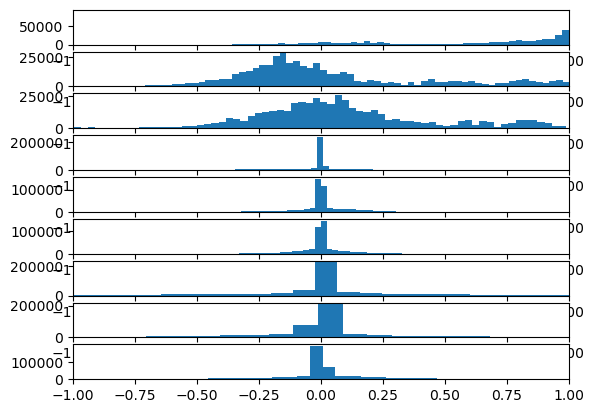

In [7]:
# plot distributions
plot_distributions(trainX)

We can see that all variables except "Total Acceleration x" behave like normal distributions. 

## Building the models

In this workshop, we will develop 2 deep learning models and evaluate the classification accuracy.



1.   LSTM model
2.   CNN model



Set common parameters across all the models

In [8]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

### LSTM model

Model design:

The model is defined as a Sequential Keras model.

The first layer of the model is set to a single LSTM hidden layer. This is followed by a dropout layer which is to reduce overfitting of the model to the training data. Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, at last we have the final softmax layer which represent the 6 classes. 

In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               44000     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [14]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 12s 104ms/step - loss: 1.3127 - accuracy: 0.4457 - val_loss: 1.4287 - val_accuracy: 0.3746
Epoch 2/10
92/92 [==============================] - 9s 103ms/step - loss: 0.9181 - accuracy: 0.6176 - val_loss: 0.8465 - val_accuracy: 0.6744
Epoch 3/10
92/92 [==============================] - 10s 106ms/step - loss: 0.8969 - accuracy: 0.6201 - val_loss: 0.8493 - val_accuracy: 0.6866
Epoch 4/10
92/92 [==============================] - 10s 106ms/step - loss: 0.6534 - accuracy: 0.7249 - val_loss: 0.7213 - val_accuracy: 0.7145
Epoch 5/10
92/92 [==============================] - 10s 112ms/step - loss: 0.7061 - accuracy: 0.7174 - val_loss: 0.6068 - val_accuracy: 0.7417
Epoch 6/10
92/92 [==============================] - 12s 128ms/step - loss: 0.5462 - accuracy: 0.7769 - val_loss: 0.5915 - val_accuracy: 0.7729
Epoch 7/10
92/92 [==============================] - 33s 359ms/step - loss: 0.4520 - accuracy: 0.8308 - val_loss: 0.5636 - val_accuracy: 0.8124


Visualize the training process (loss) w.r.t train set and the validation set

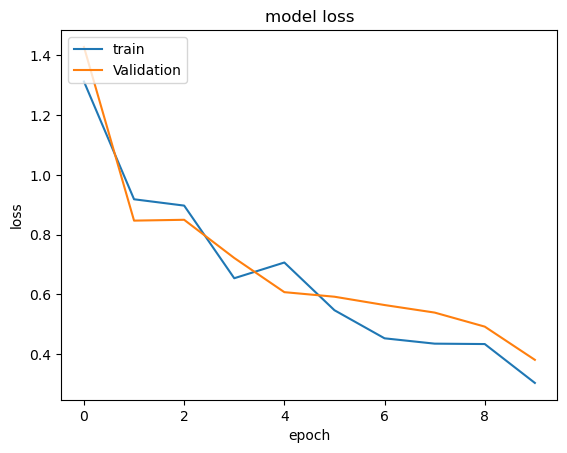

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [16]:
# evaluate model
test_loss, test_accuracy = model.evaluate(
    testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8493382930755615
93/93 [==============================] - 3s 24ms/step


In [17]:
predictions

array([[1.1904504e-03, 5.4193311e-04, 1.8248890e-04, 1.6083959e-02,
        9.8198777e-01, 1.3357329e-05],
       [8.3848229e-04, 3.9256996e-04, 1.3360444e-04, 1.3041364e-02,
        9.8558664e-01, 7.3354799e-06],
       [8.1313285e-04, 3.8279785e-04, 1.3195183e-04, 1.3082101e-02,
        9.8558271e-01, 7.2301391e-06],
       ...,
       [1.2405336e-02, 9.8028404e-01, 6.6038677e-03, 2.7378339e-05,
        6.6036684e-04, 1.9074410e-05],
       [9.8192003e-03, 9.8423487e-01, 4.9432414e-03, 3.9688781e-05,
        9.2182611e-04, 4.1194147e-05],
       [9.1404969e-01, 6.6575624e-02, 1.2989097e-02, 8.8110304e-04,
        5.4183672e-03, 8.6161162e-05]], dtype=float32)

helper function to display results

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
def display_results(testy, predictions, classNames):
    y_test = np.argmax(testy, axis=1)
    y_scores = np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x, y] = cm[x, y]  # /np.sum(cm[x,:])

    plt.figure(figsize=(10, 8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',
                     xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[431  18  47   0   0   0]
 [ 30 348  85   0   8   0]
 [ 29   5 382   0   4   0]
 [  2   1   2 413  68   5]
 [  7   5   7 106 407   0]
 [  0  15   0   0   0 522]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.86      0.87      0.87       496
           2       0.89      0.74      0.81       471
           3       0.73      0.91      0.81       420
           4       0.80      0.84      0.82       491
           5       0.84      0.77      0.80       532
           6       0.99      0.97      0.98       537

    accuracy                           0.85      2947
   macro avg       0.85      0.85      0.85      2947
weighted avg       0.86      0.85      0.85      2947



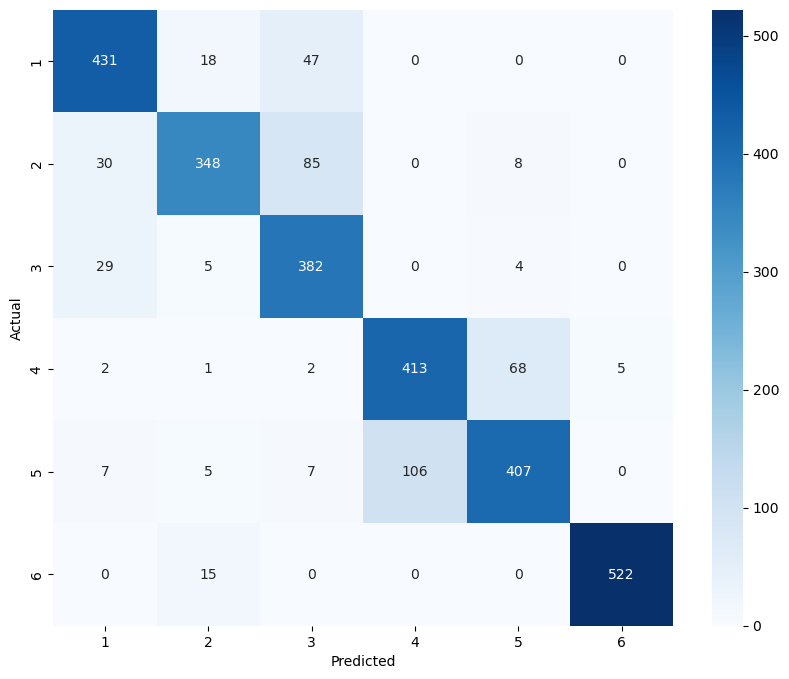

In [23]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

### CNN model

Model design:

We will define the model as having two 1D CNN layers (each with 64 filters of kernel size 4), followed by a dropout layer to avoid overfiting for training set, then a pooling layer before flattening and connecting to the fully connected layer. At last we have the final softmax layer which represent the 6 classes similar to the LSTM model.

In [24]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu',
          input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu',
          input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 125, 64)           2368      
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 64)           16448     
                                                                 
 dropout_2 (Dropout)         (None, 122, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 61, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3904)              0         
                                     

Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [26]:
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 3s 21ms/step - loss: 0.5016 - accuracy: 0.7910 - val_loss: 0.4152 - val_accuracy: 0.8851
Epoch 2/20
92/92 [==============================] - 2s 19ms/step - loss: 0.1606 - accuracy: 0.9400 - val_loss: 0.3954 - val_accuracy: 0.8919
Epoch 3/20
92/92 [==============================] - 2s 18ms/step - loss: 0.1076 - accuracy: 0.9541 - val_loss: 0.3615 - val_accuracy: 0.9001
Epoch 4/20
92/92 [==============================] - 2s 18ms/step - loss: 0.0935 - accuracy: 0.9577 - val_loss: 0.3923 - val_accuracy: 0.9014
Epoch 5/20
92/92 [==============================] - 2s 19ms/step - loss: 0.0925 - accuracy: 0.9594 - val_loss: 0.3856 - val_accuracy: 0.9109
Epoch 6/20
92/92 [==============================] - 2s 19ms/step - loss: 0.0823 - accuracy: 0.9604 - val_loss: 0.3986 - val_accuracy: 0.9143
Epoch 7/20
92/92 [==============================] - 2s 19ms/step - loss: 0.0829 - accuracy: 0.9609 - val_loss: 0.4576 - val_accuracy: 0.9123
Epoch 8/20
92

Visualize the training process (loss) w.r.t train set and the validation set

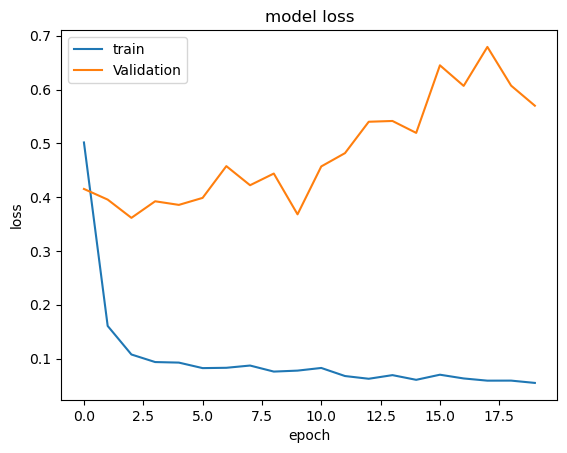

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [28]:
# evaluate model
test_loss, test_accuracy = model.evaluate(
    testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions = model.predict(testX)

Accuracy of the CNN model 0.8985409140586853
93/93 [==============================] - 0s 3ms/step


**** Confusion Matrix ****
[[455   6  35   0   0   0]
 [  4 443  24   0   0   0]
 [  1   2 417   0   0   0]
 [  0  20   0 351 116   4]
 [  0   2   0  42 488   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.92      0.95       496
           2       0.86      0.94      0.90       471
           3       0.88      0.99      0.93       420
           4       0.89      0.71      0.79       491
           5       0.81      0.92      0.86       532
           6       0.99      0.92      0.95       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



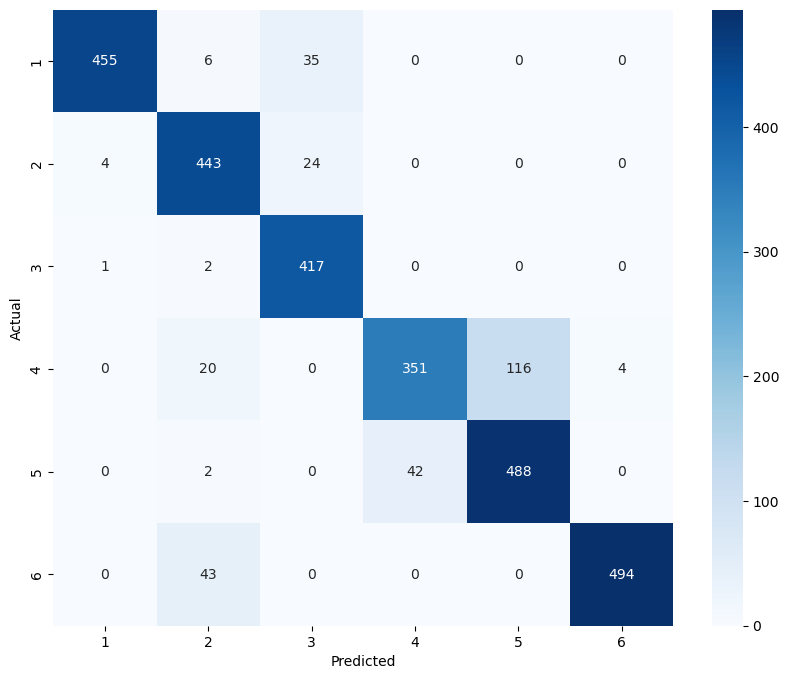

In [29]:
display_results(testy,predictions,classNames)

Predicting for a single sample

In [30]:
# we will select the first sample from the test set
sample = testX[0]
sample.shape

(128, 9)

In [31]:
# predict the results using the model, we need to input in the form of (numberOfSamples,featureLength,numberOfFeatures)
predictionForSample = model.predict(sample.reshape(1,sample.shape[0],sample.shape[1]))

1/1 [==============================] - 0s 17ms/step


In [32]:
# get the class of the sample
samplePredictedClass = np.argmax(predictionForSample, axis=1)
sampleActualClass = np.argmax(testy, axis=1)
print("Actual class: ", sampleActualClass[0])
print("Predicted class: ", samplePredictedClass[0])

Actual class:  4
Predicted class:  4
